# Demonstrating NLTK Modin Interoperability

## All the examples in this section are taken / adapted from https://www.kirenz.com/post/2021-12-11-text-mining-and-sentiment-analysis-with-nltk-and-pandas-in-python/text-mining-and-sentiment-analysis-with-nltk-and-pandas-in-python/

In [1]:
import modin.pandas as pd
import pandas
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

In [2]:
# Import some Tweets from Barack Obama 
modin_df = pd.read_csv("https://raw.githubusercontent.com/kirenz/twitter-tweepy/main/tweets-obama.csv")
modin_df.head(3)

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init(runtime_env={'env_vars': {'__MODIN_AUTOIMPORT_PANDAS__': '1'}})

2023-04-05 18:22:43,278	INFO worker.py:1553 -- Started a local Ray instance.


Unnamed: 0                created_at                   id  author_id  \
0           0  2022-05-16T21:24:35.000Z  1526312680226799618     813286   
1           1  2022-05-16T21:24:34.000Z  1526312678951641088     813286   
2           2  2022-05-16T21:24:34.000Z  1526312677521428480     813286   

                                                text  
0  It’s despicable, it’s dangerous — and it needs...  
1  We need to repudiate in the strongest terms th...  
2  This weekend’s shootings in Buffalo offer a tr...

In [3]:
modin_df['text'] = modin_df['text'].astype(str).str.lower()
modin_df.head(3)

Unnamed: 0                created_at                   id  author_id  \
0           0  2022-05-16T21:24:35.000Z  1526312680226799618     813286   
1           1  2022-05-16T21:24:34.000Z  1526312678951641088     813286   
2           2  2022-05-16T21:24:34.000Z  1526312677521428480     813286   

                                                text  
0  it’s despicable, it’s dangerous — and it needs...  
1  we need to repudiate in the strongest terms th...  
2  this weekend’s shootings in buffalo offer a tr...

In [4]:
regexp = RegexpTokenizer('\w+')

modin_df['text_token']=modin_df['text'].apply(regexp.tokenize)
modin_df.head(3)

Unnamed: 0                created_at                   id  author_id  \
0           0  2022-05-16T21:24:35.000Z  1526312680226799618     813286   
1           1  2022-05-16T21:24:34.000Z  1526312678951641088     813286   
2           2  2022-05-16T21:24:34.000Z  1526312677521428480     813286   

                                                text  \
0  it’s despicable, it’s dangerous — and it needs...   
1  we need to repudiate in the strongest terms th...   
2  this weekend’s shootings in buffalo offer a tr...   

                                          text_token  
0  [it, s, despicable, it, s, dangerous, and, it,...  
1  [we, need, to, repudiate, in, the, strongest, ...  
2  [this, weekend, s, shootings, in, buffalo, off...

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/labanyamukhopadhyay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Make a list of english stopwords
stopwords = nltk.corpus.stopwords.words("english")

# Extend the list with your own custom stopwords
my_stopwords = ['https']
stopwords.extend(my_stopwords)

In [7]:
# Remove stopwords
modin_df['text_token'] = modin_df['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
modin_df.head(3)

Unnamed: 0                created_at                   id  author_id  \
0           0  2022-05-16T21:24:35.000Z  1526312680226799618     813286   
1           1  2022-05-16T21:24:34.000Z  1526312678951641088     813286   
2           2  2022-05-16T21:24:34.000Z  1526312677521428480     813286   

                                                text  \
0  it’s despicable, it’s dangerous — and it needs...   
1  we need to repudiate in the strongest terms th...   
2  this weekend’s shootings in buffalo offer a tr...   

                                          text_token  
0  [despicable, dangerous, needs, stop, co, 0ch2z...  
1  [need, repudiate, strongest, terms, politician...  
2  [weekend, shootings, buffalo, offer, tragic, r...

In [8]:
modin_df['text_string'] = modin_df['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
modin_df[['text', 'text_token', 'text_string']].head()

text  \
0  it’s despicable, it’s dangerous — and it needs...   
1  we need to repudiate in the strongest terms th...   
2  this weekend’s shootings in buffalo offer a tr...   
3  i’m proud to announce the voyager scholarship ...   
4  across the country, americans are standing up ...   

                                          text_token  \
0  [despicable, dangerous, needs, stop, co, 0ch2z...   
1  [need, repudiate, strongest, terms, politician...   
2  [weekend, shootings, buffalo, offer, tragic, r...   
3  [proud, announce, voyager, scholarship, friend...   
4  [across, country, americans, standing, abortio...   

                                         text_string  
0         despicable dangerous needs stop 0ch2zosmhb  
1  need repudiate strongest terms politicians med...  
2  weekend shootings buffalo offer tragic reminde...  
3  proud announce voyager scholarship friend bche...  
4  across country americans standing abortion rig...

In [9]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/labanyamukhopadhyay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
all_words = ' '.join([word for word in modin_df['text_string']])
tokenized_words = nltk.tokenize.word_tokenize(all_words)

In [11]:
from nltk.probability import FreqDist

fdist = FreqDist(tokenized_words)
fdist

FreqDist({'need': 2, 'americans': 2, 'proud': 2, 'despicable': 1, 'dangerous': 1, 'needs': 1, 'stop': 1, '0ch2zosmhb': 1, 'repudiate': 1, 'strongest': 1, ...})

In [12]:
modin_df['text_string_fdist'] = modin_df['text_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 1 ]))
modin_df[['text', 'text_token', 'text_string', 'text_string_fdist']].head()

text  \
0  it’s despicable, it’s dangerous — and it needs...   
1  we need to repudiate in the strongest terms th...   
2  this weekend’s shootings in buffalo offer a tr...   
3  i’m proud to announce the voyager scholarship ...   
4  across the country, americans are standing up ...   

                                          text_token  \
0  [despicable, dangerous, needs, stop, co, 0ch2z...   
1  [need, repudiate, strongest, terms, politician...   
2  [weekend, shootings, buffalo, offer, tragic, r...   
3  [proud, announce, voyager, scholarship, friend...   
4  [across, country, americans, standing, abortio...   

                                         text_string  \
0         despicable dangerous needs stop 0ch2zosmhb   
1  need repudiate strongest terms politicians med...   
2  weekend shootings buffalo offer tragic reminde...   
3  proud announce voyager scholarship friend bche...   
4  across country americans standing abortion rig...   

                                   text_string_fdist  
0         despicable dangerous needs stop 0ch2zosmhb  
1  need repudiate strongest terms politicians med...  
2  weekend shootings buffalo offer tragic reminde...  
3  proud announce voyager scholarship friend bche...  
4  across country americans standing abortion rig...

In [13]:
#lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/labanyamukhopadhyay/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/labanyamukhopadhyay/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [14]:
from nltk.stem import WordNetLemmatizer

wordnet_lem = WordNetLemmatizer()

modin_df['text_string_lem'] = modin_df['text_string_fdist'].apply(wordnet_lem.lemmatize)

In [15]:
# check if the columns are equal
modin_df['is_equal']= (modin_df['text_string_fdist']==modin_df['text_string_lem'])

In [16]:
# show level count
modin_df.is_equal.value_counts()

True    5
Name: is_equal, dtype: int64

In [17]:
all_words_lem = ' '.join([word for word in modin_df['text_string_lem']])

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate(all_words_lem)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

## Replicating NLTK workflow with pandas

In [19]:
# Import some Tweets from Barack Obama as pandas df
pandas_df = pandas.read_csv("https://raw.githubusercontent.com/kirenz/twitter-tweepy/main/tweets-obama.csv")

In [20]:
pandas_df['text'] = pandas_df['text'].astype(str).str.lower()
pandas_df.head(3)

Unnamed: 0                created_at                   id  author_id  \
0           0  2022-05-16T21:24:35.000Z  1526312680226799618     813286   
1           1  2022-05-16T21:24:34.000Z  1526312678951641088     813286   
2           2  2022-05-16T21:24:34.000Z  1526312677521428480     813286   

                                                text  
0  it’s despicable, it’s dangerous — and it needs...  
1  we need to repudiate in the strongest terms th...  
2  this weekend’s shootings in buffalo offer a tr...

In [21]:
regexp = RegexpTokenizer('\w+')

pandas_df['text_token']=pandas_df['text'].apply(regexp.tokenize)
pandas_df.head(3)

Unnamed: 0                created_at                   id  author_id  \
0           0  2022-05-16T21:24:35.000Z  1526312680226799618     813286   
1           1  2022-05-16T21:24:34.000Z  1526312678951641088     813286   
2           2  2022-05-16T21:24:34.000Z  1526312677521428480     813286   

                                                text  \
0  it’s despicable, it’s dangerous — and it needs...   
1  we need to repudiate in the strongest terms th...   
2  this weekend’s shootings in buffalo offer a tr...   

                                          text_token  
0  [it, s, despicable, it, s, dangerous, and, it,...  
1  [we, need, to, repudiate, in, the, strongest, ...  
2  [this, weekend, s, shootings, in, buffalo, off...

In [22]:
# Remove stopwords
pandas_df['text_token'] = pandas_df['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
pandas_df.head(3)

Unnamed: 0                created_at                   id  author_id  \
0           0  2022-05-16T21:24:35.000Z  1526312680226799618     813286   
1           1  2022-05-16T21:24:34.000Z  1526312678951641088     813286   
2           2  2022-05-16T21:24:34.000Z  1526312677521428480     813286   

                                                text  \
0  it’s despicable, it’s dangerous — and it needs...   
1  we need to repudiate in the strongest terms th...   
2  this weekend’s shootings in buffalo offer a tr...   

                                          text_token  
0  [despicable, dangerous, needs, stop, co, 0ch2z...  
1  [need, repudiate, strongest, terms, politician...  
2  [weekend, shootings, buffalo, offer, tragic, r...

In [23]:
pandas_df['text_string'] = pandas_df['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
pandas_df[['text', 'text_token', 'text_string']].head()

text  \
0  it’s despicable, it’s dangerous — and it needs...   
1  we need to repudiate in the strongest terms th...   
2  this weekend’s shootings in buffalo offer a tr...   
3  i’m proud to announce the voyager scholarship ...   
4  across the country, americans are standing up ...   

                                          text_token  \
0  [despicable, dangerous, needs, stop, co, 0ch2z...   
1  [need, repudiate, strongest, terms, politician...   
2  [weekend, shootings, buffalo, offer, tragic, r...   
3  [proud, announce, voyager, scholarship, friend...   
4  [across, country, americans, standing, abortio...   

                                         text_string  
0         despicable dangerous needs stop 0ch2zosmhb  
1  need repudiate strongest terms politicians med...  
2  weekend shootings buffalo offer tragic reminde...  
3  proud announce voyager scholarship friend bche...  
4  across country americans standing abortion rig...

In [24]:
all_words = ' '.join([word for word in pandas_df['text_string']])
tokenized_words = nltk.tokenize.word_tokenize(all_words)

In [25]:
from nltk.probability import FreqDist

fdist = FreqDist(tokenized_words)
fdist

FreqDist({'need': 2, 'americans': 2, 'proud': 2, 'despicable': 1, 'dangerous': 1, 'needs': 1, 'stop': 1, '0ch2zosmhb': 1, 'repudiate': 1, 'strongest': 1, ...})

In [26]:
pandas_df['text_string_fdist'] = pandas_df['text_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 1 ]))
pandas_df[['text', 'text_token', 'text_string', 'text_string_fdist']].head()

text  \
0  it’s despicable, it’s dangerous — and it needs...   
1  we need to repudiate in the strongest terms th...   
2  this weekend’s shootings in buffalo offer a tr...   
3  i’m proud to announce the voyager scholarship ...   
4  across the country, americans are standing up ...   

                                          text_token  \
0  [despicable, dangerous, needs, stop, co, 0ch2z...   
1  [need, repudiate, strongest, terms, politician...   
2  [weekend, shootings, buffalo, offer, tragic, r...   
3  [proud, announce, voyager, scholarship, friend...   
4  [across, country, americans, standing, abortio...   

                                         text_string  \
0         despicable dangerous needs stop 0ch2zosmhb   
1  need repudiate strongest terms politicians med...   
2  weekend shootings buffalo offer tragic reminde...   
3  proud announce voyager scholarship friend bche...   
4  across country americans standing abortion rig...   

                                   text_string_fdist  
0         despicable dangerous needs stop 0ch2zosmhb  
1  need repudiate strongest terms politicians med...  
2  weekend shootings buffalo offer tragic reminde...  
3  proud announce voyager scholarship friend bche...  
4  across country americans standing abortion rig...

In [27]:
from nltk.stem import WordNetLemmatizer

wordnet_lem = WordNetLemmatizer()

pandas_df['text_string_lem'] = pandas_df['text_string_fdist'].apply(wordnet_lem.lemmatize)

In [28]:
# check if the columns are equal
pandas_df['is_equal']= (pandas_df['text_string_fdist']==pandas_df['text_string_lem'])

In [29]:
# show level count
pandas_df.is_equal.value_counts()

True    5
Name: is_equal, dtype: int64

In [30]:
all_words_lem = ' '.join([word for word in pandas_df['text_string_lem']])

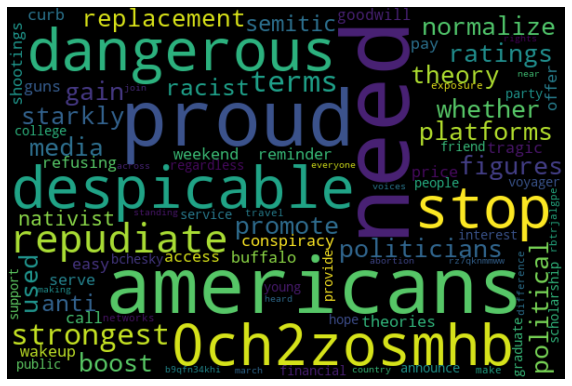

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate(all_words_lem)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');